<a href="https://colab.research.google.com/github/MalleshSonarGithub/Deep-Learning/blob/main/Face_Landmarks_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install opencv-python-headless imutils torch torchvision scikit-image pillow matplotlib

import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
#Download the DLIB Dataset
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

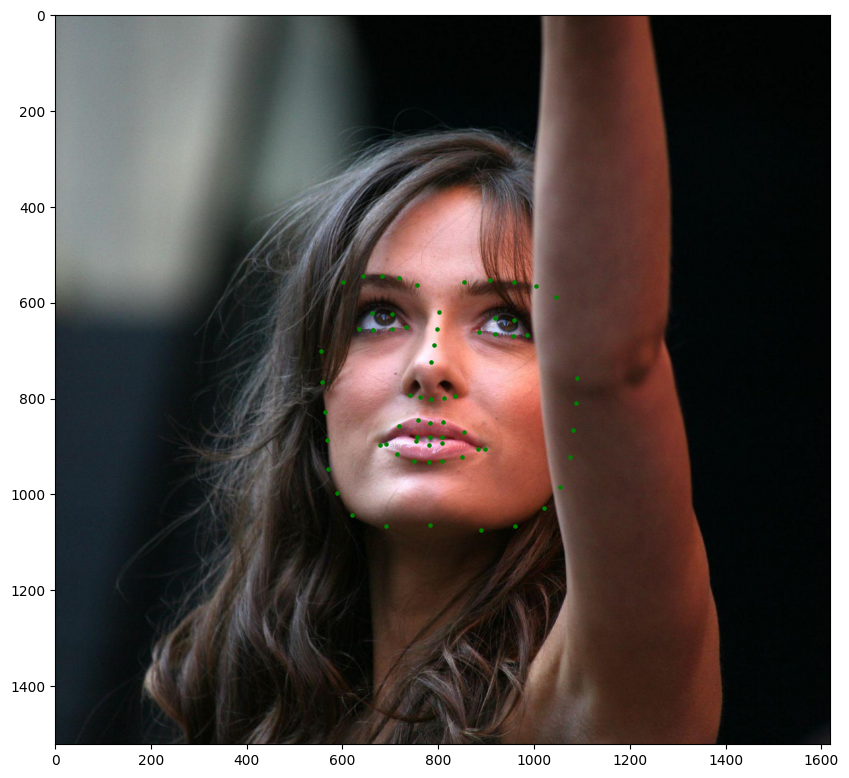

In [3]:
#Visualize the Dataset
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

In [4]:
#Creating Dataset Classes
#Now Let’s dig deeper into the classes and labels in the dataset. The labels_ibug_300W_train.xml
#consists of the input images and landmarks and bounding box to crop the face.
#I will store all these values in the list so that we could easily access them during the training process.
class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3,
                                              contrast=0.3,
                                              saturation=0.3,
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [5]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

/tmp/ipython-input-4291540521.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


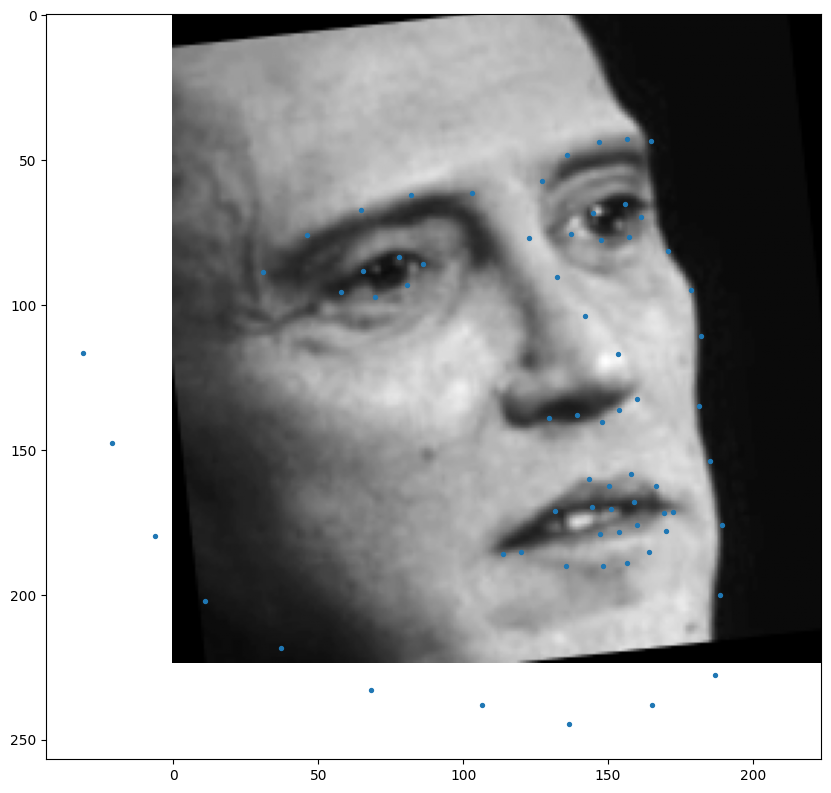

In [6]:
#Visualize Train Transforms:

#Now let’s have a quick look at what we have done until now.
#I will just visualize the dataset by performing the transformation that the above classes will provide to the dataset:
image, landmarks = dataset[0]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);


In [7]:
#Split the Dataset for Training and Prediction of Face Landmarks
#Now, to move further, I will split the dataset into a train and a valid dataset:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
#Testing the shape of input data:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

/tmp/ipython-input-4291540521.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-4291540521.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-4291540521.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
/tmp/ipython-input-4291540521.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])


In [9]:
#Define the Face Landmarks Detection Model
#Now I will use the ResNet18 as our fundamental framework. I will modify the first and last layers so that the layers will fit easily for our purpose:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [10]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

In [14]:
torch.autograd.set_detect_anomaly(True)
network = Network().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

...
    print('--------------------------------------------------')

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth')
        print("\nMinimum Validation Loss: {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')

print('Training Complete')
print("Total Elapsed Time: {:.0f}s".format(time.time()-start_time))

IndentationError: unexpected indent (ipython-input-2161690664.py, line 10)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx